<a href="https://colab.research.google.com/github/kuds/rl-lunar-lander/blob/main/%5BLunar%20Lander%5D%20Deep%20Q-Network%20(DQN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with Gymansium's LunarLander-v3 environment.

### References:
 - [Udacity - Deep Reinforcement Learning](https://github.com/udacity/deep-reinforcement-learning/)
 - [Gymansium - Documentation](https://gymnasium.farama.org/index.html)
 - [Stable Baselines3 - Documentation](https://stable-baselines3.readthedocs.io/en/master/)


In [1]:
!pip install swig

In [2]:
!pip install gymnasium gymnasium[box2d] stable_baselines3

In [3]:
import gymnasium
from gymnasium.wrappers import RecordVideo

import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

from collections import namedtuple, deque
import torch.optim as optim
import os
import platform
import time
import random
import numpy
import torch
import torch.backends.quantized
import scipy
import IPython
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot
from importlib.metadata import version
%matplotlib inline

In [4]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Scipy Version: {version('scipy')}")
print(f"Swig Version: {version('swig')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")
print(f"IPython Version: {version('ipython')}")

Python Version: 3.11.12
Torch Version: 2.6.0+cu124
Is Cuda Available: True
Cuda Version: 12.4
Gymnasium Version: 1.1.1
Numpy Version: 2.0.2
Scipy Version: 1.15.3
Swig Version: 4.3.1
Stable Baselines3 Version: 2.6.0
IPython Version: 7.34.0


### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [5]:
rl_type = "DQN"
env_str = "LunarLander-v3"
log_dir = "./logs/{}".format(env_str)
name_prefix = "lunar_lander"

In [6]:
env = gymnasium.make(env_str)
print("Observation Space Size: ", env.observation_space.shape)
print('Actions Space: ', env.action_space)
env.close()

Observation Space Size:  (8,)
Actions Space:  Discrete(4)


<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute


### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Alternatively, you can skip to the next step below (**4. Watch a Smart Agent!**), to load the saved model weights from a pre-trained agent.

In [7]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [8]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return numpy.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(numpy.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(numpy.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(numpy.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(numpy.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(numpy.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(numpy.vstack([e.done for e in experiences if e is not None]).astype(numpy.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [9]:
def dqn(n_episodes=4000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state,info = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, info,_ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, numpy.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, numpy.mean(scores_window)))
        if numpy.mean(scores_window)>=225.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, numpy.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_lunar.pth')
            break
    return scores

Episode 100	Average Score: -149.21
Episode 200	Average Score: -103.92
Episode 300	Average Score: -51.06
Episode 400	Average Score: -25.83
Episode 500	Average Score: 3.88
Episode 600	Average Score: 63.28
Episode 700	Average Score: 160.91
Episode 794	Average Score: 225.48
Environment solved in 694 episodes!	Average Score: 225.48


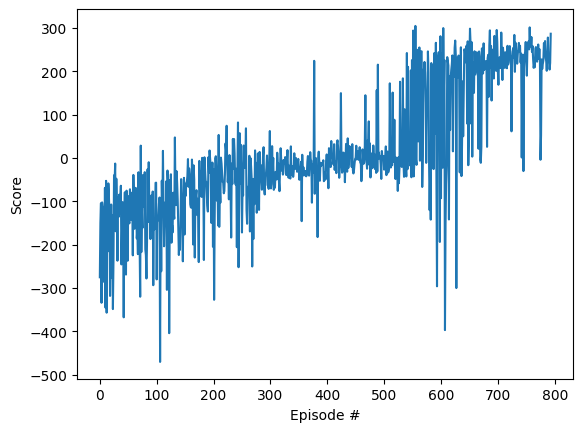

In [10]:
# Train DQN model for Lunar Lander
env = gymnasium.make(env_str)
agent = Agent(state_size=8, action_size=4, seed=0)
scores = dqn(n_episodes=1000)
env.close()

# Plot the scores
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(111)
matplotlib.pyplot.plot(numpy.arange(len(scores)), scores)
matplotlib.pyplot.ylabel('Score')
matplotlib.pyplot.xlabel('Episode #')
matplotlib.pyplot.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [11]:
env = gymnasium.make(env_str, render_mode='rgb_array')

# Wrap the environment to record video
env = RecordVideo(env, video_folder='./video', episode_trigger=lambda e: True)

agent.qnetwork_local.load_state_dict(torch.load('checkpoint_lunar.pth'))

for i in range(3):
    state,info = env.reset()
    for j in range(500):
        action = agent.act(state)
        env.render()
        state, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            break

env.close()

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN!
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  

## Using Stable Baselines3 Library for DQN

In [12]:
# Create Training Environment
env = make_vec_env(env_str, n_envs=1)

# Create Evaluation Environment
env_val = make_vec_env(env_str, n_envs=1)

eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=25_000,
                             render=False,
                             deterministic=True,
                             n_eval_episodes=20)

# Initialize DQN
model = DQN('MlpPolicy', env, verbose=0)

# Train the model
model.learn(total_timesteps=500_000,
            progress_bar=True,
            callback=eval_callback)

# Save the model
model.save(os.path.join(log_dir, "final_model"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

Output()

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=25000, episode_reward=-128.24 +/- 16.02

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=50000, episode_reward=-118.96 +/- 23.08

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=75000, episode_reward=-114.49 +/- 58.82

Episode length: 982.50 +/- 76.28

New best mean reward!

Eval num_timesteps=100000, episode_reward=-107.68 +/- 23.32

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=125000, episode_reward=-119.57 +/- 26.42

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=150000, episode_reward=-108.01 +/- 19.19

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=175000, episode_reward=-112.22 +/- 22.43

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=200000, episode_reward=-61.79 +/- 34.22

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=225000, episode_reward=-58.38 +/- 32.60

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=250000, episode_reward=-37.14 +/- 55.35

Episode length: 997.30 +/- 11.77

New best mean reward!

Eval num_timesteps=275000, episode_reward=160.24 +/- 62.67

Episode length: 781.65 +/- 116.35

New best mean reward!

Eval num_timesteps=300000, episode_reward=99.51 +/- 114.10

Episode length: 828.75 +/- 147.52

Eval num_timesteps=325000, episode_reward=131.15 +/- 131.68

Episode length: 446.70 +/- 202.12

Eval num_timesteps=350000, episode_reward=101.49 +/- 124.66

Episode length: 503.20 +/- 231.20

Eval num_timesteps=375000, episode_reward=82.40 +/- 133.13

Episode length: 483.65 +/- 253.26

Eval num_timesteps=400000, episode_reward=60.41 +/- 144.77

Episode length: 449.10 +/- 220.35

Eval num_timesteps=425000, episode_reward=-60.01 +/- 119.87

Episode length: 620.75 +/- 289.32

Eval num_timesteps=450000, episode_reward=30.45 +/- 140.19

Episode length: 568.50 +/- 313.70

Eval num_timesteps=475000, episode_reward=44.05 +/- 136.11

Episode length: 584.10 +/- 285.94

Eval num_timesteps=500000, episode_reward=11.54 +/- 98.48

Episode length: 526.05 +/- 297.73

Mean reward: 55.98 +/- 135.70


In [13]:
# Create Elevation environment
env = make_vec_env(env_str, n_envs=1, seed=0)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = DQN.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing Lunar Lander
best_model_file_name = "best_model_{}".format(name_prefix)
env = VecVideoRecorder(env,
                       log_dir,
                       video_length=5000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix=best_model_file_name)

obs = env.reset()
for _ in range(5000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
      break

env.close()

Best Model - Mean reward: 182.29 +/- 44.02
Moviepy - Building video /content/logs/LunarLander-v3/best_model_lunar_lander-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/logs/LunarLander-v3/best_model_lunar_lander-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/LunarLander-v3/best_model_lunar_lander-step-0-to-step-5000.mp4


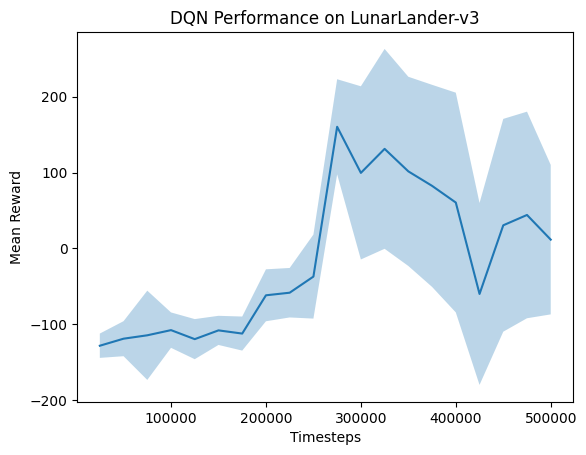

In [14]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel("Timesteps")
matplotlib.pyplot.ylabel("Mean Reward")
matplotlib.pyplot.title(f"{rl_type} Performance on {env_str}")
matplotlib.pyplot.show()